# Find A Raster Tile

**Goal**: Find the raster tile your pit falls in.

**Approach**: 
1. Grab the pit location from the a pit layer in the database
2. Perform an intersect on all raster tiles with the pit location 
3. Plot 


### Step 1. Grab the pit location from the layer data

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, LayerData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape
from rasterio import MemoryFile
import matplotlib.pyplot as plt
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio

# PIT Site Identifier
site_id = '5S31'

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id == site_id)
layers = q.all()

# Grab the pit location from a single layer
p = layers[0].geom
p_shp = to_shape(p)

### Step 2. Perform an intersect on all raster tiles with the pit location 

In [2]:
# Grab the raster as a tile that intersects with our pit and convert it to a geotiff
print('Grabbing rasters that overlap on the point {}'.format(p_shp))

# Grab the returned raster as a tiff
q = session.query(func.ST_AsTiff(ImageData.raster))

# Filter rasters by where a tile intersects wihtour pit location
rasters = q.filter(gfunc.ST_Intersects(ImageData.raster, p)).all()

# Convert it to a rasterio dataset for easy plotting
dataset = raster_to_rasterio(session, rasters)[0]


Grabbing rasters that overlap on the point POINT (745458 4322762)


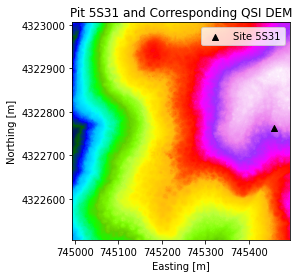

In [3]:
fig,ax = plt.subplots()

# Plot the rasterio dataset
show(dataset.read(1), ax=ax, transform=dataset.transform, cmap='gist_ncar')

# Add to our plot the pit location
gpd.GeoSeries(p_shp).plot(ax=ax, color='k', marker='^', label="Site {}".format(site_id))

# Add some labeling
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} and Corresponding QSI DEM'.format(site_id))
ax.legend()

In [4]:
# Close all our datasets held in memory
for d in datasets:
    d.close()

# Close the session to avoid hanging transactions
session.close()